# Análisis de datos del mercado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import cmath

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

## Extracción de datos

In [2]:
data = {}
for i in range(2014,2024):
    data[i] = pd.read_excel(f"Demanda_Energia_SIN_{i}.xlsx",header=3,parse_dates=["Fecha"])
    data[i]["Demanda GWh"] = data[i]["Demanda Energia SIN kWh"]/(10**6)
    data[i] = data[i][["Fecha","Demanda GWh"]]

demanda = pd.concat(data.values()).reset_index(drop=True)#.set_index("Fecha")[["Demanda GWh"]]

In [3]:
demanda

,Fecha,Demanda GWh
0,2014-01-01,129.772796
1,2014-01-02,153.474119
2,2014-01-03,162.368017
3,2014-01-04,157.250885
4,2014-01-05,143.641164
...,...,...
3646,2023-12-27,222.323144
3647,2023-12-28,221.234880
3648,2023-12-29,216.314117
3649,2023-12-30,204.576142


## Exploración de datos

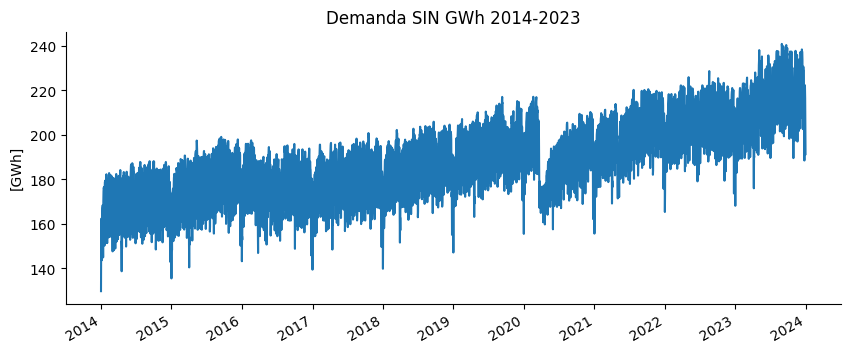

In [5]:
# Visualización
demanda_plot = demanda.set_index("Fecha")
demanda_plot["Demanda GWh"].plot(kind='line', figsize=(10, 4), title='Demanda SIN GWh 2014-2023', xlabel='', ylabel='[GWh]')
plt.gca().spines[['top', 'right']].set_visible(False)

In [6]:
# Demanda anual
demanda["Año"] = demanda["Fecha"].dt.year
demanda_anual = demanda[["Año", "Demanda GWh"]].groupby("Año").sum()
demanda_anual

,Demanda GWh
Año,
2014,63571.247863
2015,66006.529529
2016,66319.473679
2017,66893.067654
2018,69126.693795
2019,71925.009342
2020,70422.150219
2021,74116.613511
2022,76657.114139


In [90]:
#demanda_anual.pct_change()*100

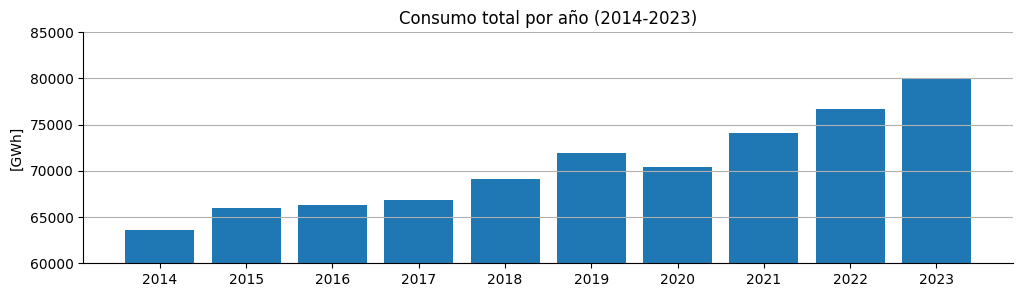

In [8]:
# Visualización demanda anual
plt.figure(figsize = (12, 3))
plt.bar(x=demanda_anual.index,height=demanda_anual["Demanda GWh"])
plt.xticks(range(2014,2024))
plt.ylim([60000,85000])
plt.title("Consumo total por año (2014-2023)")
plt.ylabel("[GWh]")
plt.grid(axis="y")
plt.gca().spines[['top', 'right']].set_visible(False)

In [9]:
# Consumo mes a mes
demanda["Año-Mes"] = demanda["Fecha"].dt.strftime('%Y-%m')
demanda_media_mensual = (demanda[["Año-Mes","Demanda GWh"]].groupby("Año-Mes").mean())
demanda_media_mensual.index = pd.to_datetime(demanda_media_mensual.index).to_period("M")

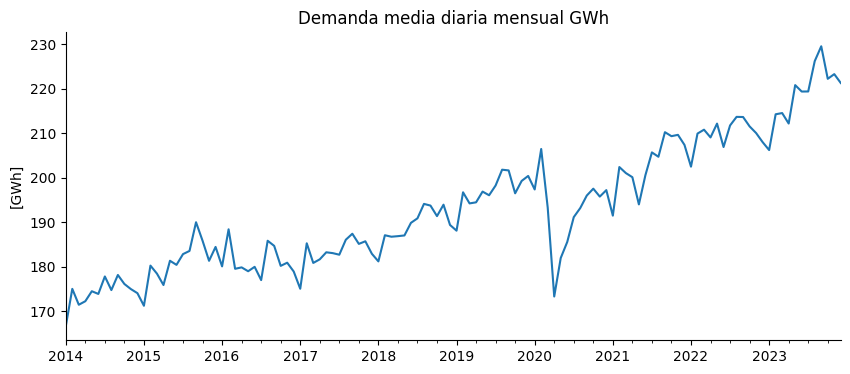

In [79]:
# Visualización mes a mes
demanda_media_mensual['Demanda GWh'].plot(kind='line', figsize=(10, 4), title='Demanda media diaria mensual GWh', xlabel='', ylabel='[GWh]')
plt.gca().spines[['top', 'right']].set_visible(False)

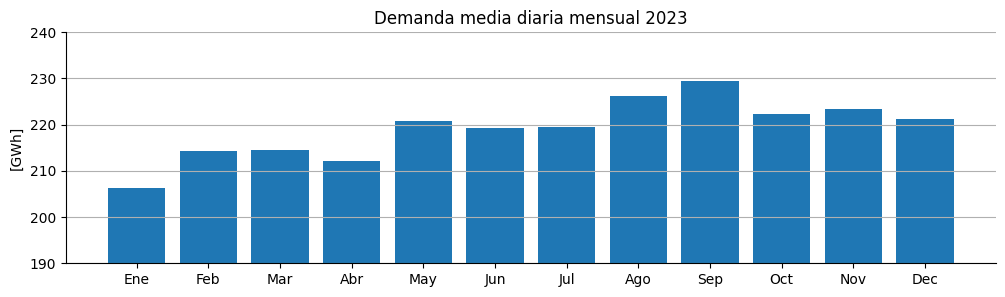

In [11]:
# Visualización demanda mensual 2023
demanda_media_mensual2023 = demanda_media_mensual.loc["2023"]
orden_meses = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dec"]
demanda_media_mensual2023.index = orden_meses
plt.figure(figsize = (12, 3))
plt.bar(x=demanda_media_mensual2023.index,height=demanda_media_mensual2023["Demanda GWh"])
plt.ylim([190,240])
plt.title("Demanda media diaria mensual 2023")
plt.grid(axis="y")
plt.ylabel("[GWh]")
plt.gca().spines[['top', 'right']].set_visible(False)

In [86]:
demanda["Mes"] = demanda["Fecha"].dt.month
demanda.set_index("Fecha",inplace=True)
Lmin=[]
Lmax=[]
for i in range(2014,2024):
    df = demanda.loc[f"{i}"]
    df2 = df.groupby("Mes").mean(numeric_only=True)
    df2.index = orden_meses
    Lmin.append([i,df2["Demanda GWh"].idxmin(),df2["Demanda GWh"].min()])
    Lmax.append([i,df2["Demanda GWh"].idxmax(),df2["Demanda GWh"].max()])
Lmin = pd.DataFrame(data=Lmin,columns=["Año","Mes con menor demanda","GWh"])
Lmin.set_index("Año",inplace=True)
Lmax = pd.DataFrame(data=Lmax,columns=["Año","Mes con mayor demanda","GWh"])
Lmax.set_index("Año",inplace=True)
demanda.reset_index(inplace=True)

In [87]:
print(Lmin)
print()
print(Lmin["Mes con menor demanda"].value_counts())

     Mes con menor demanda         GWh
Año                                   
2014                   Ene  166.673865
2015                   Ene  171.279229
2016                   Jul  177.041700
2017                   Ene  175.101053
2018                   Ene  181.244487
2019                   Ene  188.142778
2020                   Abr  173.360290
2021                   Ene  191.512369
2022                   Ene  202.513149
2023                   Ene  206.239330

Mes con menor demanda
Ene    8
Jul    1
Abr    1
Name: count, dtype: int64


In [88]:
print(Lmax)
print()
print(Lmax["Mes con mayor demanda"].value_counts())

     Mes con mayor demanda         GWh
Año                                   
2014                   Sep  178.192478
2015                   Sep  190.035840
2016                   Feb  188.445654
2017                   Sep  187.452634
2018                   Ago  194.154141
2019                   Ago  201.832205
2020                   Feb  206.482632
2021                   Sep  210.258151
2022                   Ago  213.693067
2023                   Sep  229.544547

Mes con mayor demanda
Sep    5
Ago    3
Feb    2
Name: count, dtype: int64


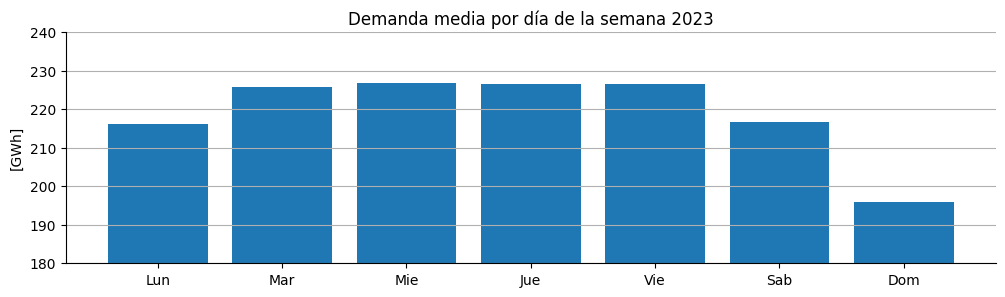

In [85]:
# Visualización demanda diaria semanal 2023
demanda2023 = demanda.set_index("Fecha").loc["2023"].reset_index()
demanda2023["DoY"] = demanda2023["Fecha"].dt.dayofweek
demanda_dia_semana2023 = demanda2023[["DoY","Demanda GWh"]].groupby("DoY").mean()
orden_dias = ["Lun","Mar","Mie","Jue","Vie","Sab","Dom"]
demanda_dia_semana2023.index=orden_dias
plt.figure(figsize = (12, 3))
plt.bar(x=demanda_dia_semana2023.index,height=demanda_dia_semana2023["Demanda GWh"])
plt.ylim([180,240])
plt.title("Demanda media por día de la semana 2023")
plt.grid(axis="y")
plt.ylabel("[GWh]")
plt.gca().spines[['top', 'right']].set_visible(False)

In [16]:
demanda["DoY"] = demanda["Fecha"].dt.dayofweek
demanda.set_index("Fecha",inplace=True)
Lmin=[]
Lmax=[]
for i in range(2014,2024):
    df = demanda.loc[f"{i}"]
    df2 = df.groupby("DoY").mean(numeric_only=True)
    df2.index = orden_dias
    #print(df2)
    Lmin.append([i,df2["Demanda GWh"].idxmin()])
    Lmax.append([i,df2["Demanda GWh"].idxmax()])
Lmin = pd.DataFrame(data=Lmin,columns=["Año","Día con menor demanda"])
Lmin.set_index("Año",inplace=True)
Lmax = pd.DataFrame(data=Lmax,columns=["Año","Día con mayor demanda"])
Lmax.set_index("Año",inplace=True)
demanda.reset_index(inplace=True)

In [17]:
print(Lmin)
print()
print(Lmin.value_counts())

     Día con menor demanda
Año                       
2014                   Dom
2015                   Dom
2016                   Dom
2017                   Dom
2018                   Dom
2019                   Dom
2020                   Dom
2021                   Dom
2022                   Dom
2023                   Dom

Día con menor demanda
Dom                      10
Name: count, dtype: int64


In [18]:
print(Lmax)
print()
print(Lmax.value_counts())

     Día con mayor demanda
Año                       
2014                   Mar
2015                   Mie
2016                   Jue
2017                   Mie
2018                   Jue
2019                   Vie
2020                   Mar
2021                   Jue
2022                   Mie
2023                   Mie

Día con mayor demanda
Mie                      4
Jue                      3
Mar                      2
Vie                      1
Name: count, dtype: int64


In [19]:
def plot_decompose(data,model,T):
    components = seasonal_decompose(data, model=model,period=T)
    components.plot()
    plt.show()

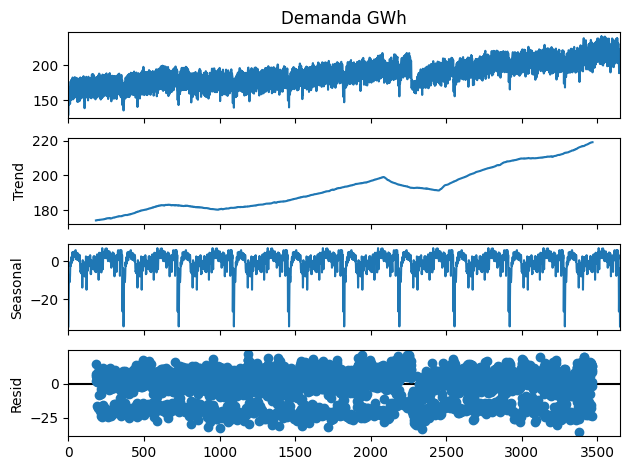

In [20]:
plot_decompose(demanda["Demanda GWh"],"aditive",365)

In [83]:
def extraerMagnitud(fft):
    fase=[]
    magn=[]
    for XX in fft:
        [X,P]=cmath.polar(XX)
        fase.append(P)
        magn.append(X)
    return magn

def periodicidad_dias(data):
    data_norm = (data-data.mean())/data.std()
    fft1 = np.fft.fft(data_norm)
    mag = extraerMagnitud(fft1)
    plt.figure()
    plt.plot(mag)
    plt.title("Magnitud Fourier")
    mags = pd.Series(mag)
    mags_order=mags[:len(mags)//2].sort_values(ascending=False)
    L=[]
    for i in range(5):
        L.append(len(mags)/mags_order.index[i])
    return pd.Series(L)

0    3651.000000
1       6.994253
2    1825.500000
3    1217.000000
4     730.200000
dtype: float64

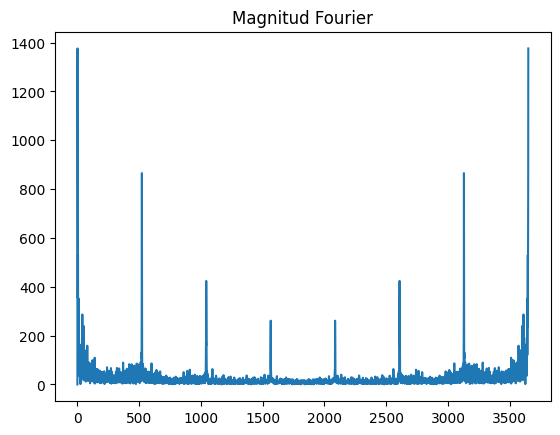

In [84]:
L = periodicidad_dias(demanda.loc[:,"Demanda GWh"])
L

## Predicción de la demanda

In [23]:
demanda10años = demanda[["Fecha","Demanda GWh"]]
demanda10años

,Fecha,Demanda GWh
0,2014-01-01,129.772796
1,2014-01-02,153.474119
2,2014-01-03,162.368017
3,2014-01-04,157.250885
4,2014-01-05,143.641164
...,...,...
3646,2023-12-27,222.323144
3647,2023-12-28,221.234880
3648,2023-12-29,216.314117
3649,2023-12-30,204.576142


In [24]:
demanda2024 =  pd.read_excel("Demanda_Energia_SIN_2024.xlsx",header=3,parse_dates=["Fecha"])
demanda2024["Demanda GWh"] = demanda2024["Demanda Energia SIN kWh"]/(10**6)
demanda2024 = demanda2024.loc[:120,["Fecha","Demanda GWh"]]
demanda2024

,Fecha,Demanda GWh
0,2024-01-01,176.289473
1,2024-01-02,203.919248
2,2024-01-03,214.869534
3,2024-01-04,219.426754
4,2024-01-05,221.262953
...,...,...
116,2024-04-26,224.668354
117,2024-04-27,217.171197
118,2024-04-28,195.060844
119,2024-04-29,223.038657


In [25]:
data10años = demanda10años["Demanda GWh"].values.reshape(-1, 1)
data2024 = demanda2024["Demanda GWh"].values.reshape(-1, 1)

In [61]:
# Normalización de datos
full_data = np.concatenate((data10años, data2024))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_full_data = scaler.fit_transform(full_data)

scaled_data10años = scaled_full_data[:len(data10años)]
scaled_data2024 = scaled_full_data[len(data10años):]

In [67]:
# Crear secuencias para el modelo LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # 60 días para predecir
X_train, y_train = create_sequences(scaled_data10años, seq_length)
X_test, y_test = create_sequences(np.concatenate((scaled_data10años[-seq_length:], scaled_data2024)), seq_length)

In [28]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
90/90 [==============================] - 17s 70ms/step - loss: 0.0201 - val_loss: 0.0136
Epoch 2/20
90/90 [==============================] - 6s 62ms/step - loss: 0.0107 - val_loss: 0.0161
Epoch 3/20
90/90 [==============================] - 5s 53ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 4/20
90/90 [==============================] - 6s 70ms/step - loss: 0.0107 - val_loss: 0.0136
Epoch 5/20
90/90 [==============================] - 5s 53ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 6/20
90/90 [==============================] - 5s 58ms/step - loss: 0.0107 - val_loss: 0.0114
Epoch 7/20
90/90 [==============================] - 6s 66ms/step - loss: 0.0109 - val_loss: 0.0168
Epoch 8/20
90/90 [==============================] - 5s 54ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 9/20
90/90 [==============================] - 6s 71ms/step - loss: 0.0108 - val_loss: 0.0172
Epoch 10/20
90/90 [==============================] - 5s 55ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 11

In [69]:
# Desempeño del modelo

train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
mse = mean_squared_error(y_train_actual, train_predictions)
print(f"Error Cuadrático Medio del conjunto de entrenamiento (2014-2023): {mse}")

test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
mse2024 = mean_squared_error(y_test_actual, test_predictions)
print(f'Error Cuadrático Medio del conjunto de prueba (2024): {mse2024}')

113/113 [==============================] - 2s 16ms/step
Error Cuadrático Medio del conjunto de entrenamiento (2014-2023): 54.52962977889721
4/4 [==============================] - 0s 16ms/step
Error Cuadrático Medio del conjunto de prueba (2024): 75.85156395217777


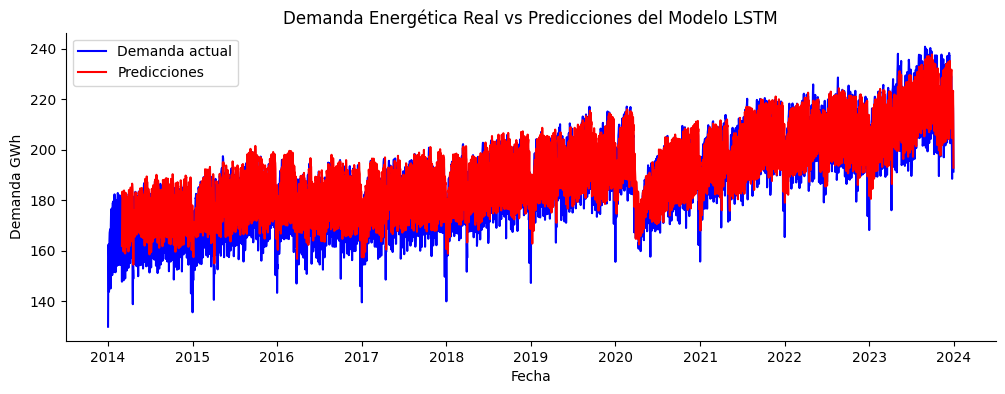

In [76]:
fechas = demanda10años["Fecha"]
fechas_predicciones = fechas[seq_length:len(fechas)]

plt.figure(figsize=(12, 4))
plt.plot(fechas, demanda10años["Demanda GWh"], color='blue', label='Demanda actual')
plt.plot(fechas_predicciones, train_predictions, color='red', label='Predicciones')
plt.title('Demanda Energética Real vs Predicciones del Modelo LSTM')
plt.xlabel('Fecha')
plt.ylabel('Demanda GWh')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

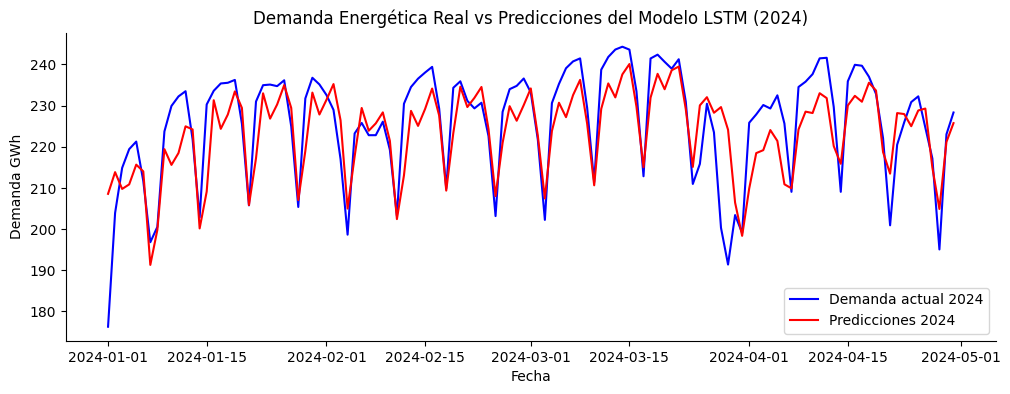

In [73]:
fechas2024 = demanda2024["Fecha"]

plt.figure(figsize=(12, 4))
plt.plot(fechas2024, data2024, color='blue', label='Demanda actual 2024')
plt.plot(fechas2024, test_predictions, color='red', label='Predicciones 2024')
plt.title('Demanda Energética Real vs Predicciones del Modelo LSTM (2024)')
plt.xlabel('Fecha')
plt.ylabel('Demanda GWh')
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)